In [2]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from random import randint


from modules.data_fetcher import download_historical_data

2023-04-10 20:57:04.570951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 20:57:05.090446: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-10 20:57:05.090472: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-10 20:57:07.090398: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Transformer encoder


In [27]:
symbol = "BTC-USDT"

df = download_historical_data(symbol, "1hour").loc["2020-11-20":]
df["Log_Close"] = np.log(df.Close.apply(lambda x: 1.0 if x == 0.0 else x))
df["Returns"] = df.Close.pct_change()
df["Log_Returns"] = df.Log_Close.pct_change()
df["Log_Volume"] = np.log(np.abs(df.Volume.apply(lambda x: 1.0 if x == 0.0 else x)))
df["Vol20"] = df.Log_Returns.rolling(20).std()
df["EMA20"] = df.Close.ewm(20).mean()
df["Target"] = (df["Close"].shift(-5) > df["Close"]).astype(int)
df.dropna(inplace=True)

df.head()

,Timestamp,Open,Close,High,Low,Amount,Volume,Log_Close,Returns,Log_Returns,Log_Volume,Vol20,EMA20,Target
Date,,,,,,,,,,,,,,
2020-11-20 20:00:00,1.605899e+09,18582.6,18626.1,18658.0,18532.6,37.037587,6.893380e+05,9.832319,0.002341,0.000238,13.443487,0.000658,18338.482479,1
2020-11-20 21:00:00,1.605902e+09,18626.2,18627.1,18687.6,18558.7,48.514027,9.047119e+05,9.832373,0.000054,0.000005,13.715372,0.000654,18359.364784,1
2020-11-20 22:00:00,1.605906e+09,18627.0,18576.5,18645.1,18512.4,58.444076,1.086463e+06,9.829653,-0.002716,-0.000277,13.898438,0.000633,18374.695941,1
2020-11-20 23:00:00,1.605910e+09,18576.5,18617.3,18619.7,18488.7,51.350270,9.529672e+05,9.831847,0.002196,0.000223,13.767336,0.000631,18391.440450,1
2020-11-21 00:00:00,1.605913e+09,18617.3,18659.4,18721.5,18550.9,95.569442,1.782114e+06,9.834105,0.002261,0.000230,14.393311,0.000629,18409.547487,0


In [28]:
std_scaler = StandardScaler()

X, y = (
    std_scaler.fit_transform(df.drop(columns=["Target", "Timestamp"]).values),
    df["Target"].values,
)  # to_categorical(df['Target'].values)

n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(
    X.reshape((X.shape[0], X.shape[1], 1)), y, test_size=0.2, shuffle=False
)

x_train, y_train

(array([[[-1.20338239e+00],
         [-1.20032174e+00],
         [-1.20477630e+00],
         ...,
         [-2.50415090e+00],
         [ 1.18638058e-02],
         [-1.22237741e+00]],
 
        [[-1.20025086e+00],
         [-1.20024992e+00],
         [-1.20266252e+00],
         ...,
         [-2.22756841e+00],
         [ 5.20178823e-04],
         [-1.22087498e+00]],
 
        [[-1.20019340e+00],
         [-1.20388430e+00],
         [-1.20569750e+00],
         ...,
         [-2.04133906e+00],
         [-5.59214921e-02],
         [-1.21977194e+00]],
 
        ...,
 
        [[-1.13405790e+00],
         [-1.13182148e+00],
         [-1.13653578e+00],
         ...,
         [ 2.93758101e-01],
         [-1.04203714e+00],
         [-1.14594302e+00]],
 
        [[-1.13168771e+00],
         [-1.13372486e+00],
         [-1.13832820e+00],
         ...,
         [ 5.18516077e-02],
         [-1.06097120e+00],
         [-1.14542070e+00]],
 
        [[-1.13365569e+00],
         [-1.12723899e+00],
    

In [29]:
from tensorflow import keras

from tensorflow.keras import layers

"""
We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.
The projection layers are implemented through `keras.layers.Conv1D`.
"""


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


"""
The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.
"""


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(
        x
    )  # layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


"""
## Train and evaluate
"""

input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="binary_crossentropy",  # loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # AdamW or NovoGrad
    metrics=["accuracy"],  # metrics=["sparse_categorical_accuracy"],
)


model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
    ],
    use_multiprocessing=True,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
209/209 [==============================] - 76s 296ms/step - loss: 0.7093 - accuracy: 0.5052 - val_loss: 0.7166 - val_accuracy: 0.4864
Epoch 2/200
209/209 [==============================] - 66s 314ms/step - loss: 0.7069 - accuracy: 0.4957 - val_loss: 0.7092 - val_accuracy: 0.4855
Epoch 3/200
209/209 [==============================] - 99s 472ms/step - loss: 0.7015 - accuracy: 0.5102 - val_loss: 0.7052 - val_accuracy: 0.4831
Epoch 4/200
209/209 [==============================] - 96s 459ms/step - loss: 0.6987 - accuracy: 0.5127 - val_loss: 0.7022 - val_accuracy: 0.4825
Epoch 5/200
209/209 [==============================] - 99s 476ms/step - loss: 0.6993 - accuracy: 0.5076 - val_loss: 0.7023 - val_accuracy: 0.4804
Epoch 6/200
209/209 [==============================] - 92s 441ms/step - loss: 0.6969 - accuracy: 0.5135 - val_loss: 0.7020 - val_accuracy: 0.4807
Epoch 7/200
209/209 [==============================] - 59s 281ms/step - loss: 0.6972 - accuracy: 0.5230 - val_loss: 0.7015 -

[0.6959822773933411, 0.5029911398887634]

# Time2Vec


## Example 1


In [ ]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name="Time2VecLayer")
        self.k = kernel_size

    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(
            name="wb", shape=(input_shape[1],), initializer="uniform", trainable=True
        )
        self.bb = self.add_weight(
            name="bb", shape=(input_shape[1],), initializer="uniform", trainable=True
        )
        # periodic
        self.wa = self.add_weight(
            name="wa",
            shape=(1, input_shape[1], self.k),
            initializer="uniform",
            trainable=True,
        )
        self.ba = self.add_weight(
            name="ba",
            shape=(1, input_shape[1], self.k),
            initializer="uniform",
            trainable=True,
        )
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = np.dot(inputs, self.wa) + self.ba
        wgts = np.sin(dp)  # or np.cos(.)

        ret = np.concatenate([np.expand_dims(bias, -1), wgts], -1)
        ret = np.reshape(ret, (-1, inputs.shape[1] * (self.k + 1)))
        return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * (self.k + 1))

In [ ]:
from tensorflow_addons.layers import MultiHeadAttention


class AttentionBlock(keras.Model):
    def __init__(
        self,
        name="AttentionBlock",
        num_heads=2,
        head_size=128,
        ff_dim=None,
        dropout=0,
        **kwargs
    ):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(
            num_heads=num_heads, head_size=head_size, dropout=dropout
        )
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(
            filters=ff_dim, kernel_size=1, activation="relu"
        )
        # self.ff_conv2 at build()
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1)

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)

        x = self.ff_conv1(x)
        x = self.ff_conv2(x)
        x = self.ff_dropout(x)

        x = self.ff_norm(inputs + x)
        return x

In [ ]:
class ModelTrunk(keras.Model):
    def __init__(
        self,
        name="ModelTrunk",
        time2vec_dim=1,
        num_heads=2,
        head_size=128,
        ff_dim=None,
        num_layers=1,
        dropout=0,
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.time2vec = Time2Vec(kernel_size=time2vec_dim)
        if ff_dim is None:
            ff_dim = head_size
        self.dropout = dropout
        self.attention_layers = [
            AttentionBlock(
                num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout
            )
            for _ in range(num_layers)
        ]

    def call(self, inputs):
        time_embedding = keras.layers.TimeDistributed(self.time2vec)(inputs)
        x = np.concatenate([inputs, time_embedding], -1)
        for attention_layer in self.attention_layers:
            x = attention_layer(x)

        return np.reshape(
            x, (-1, x.shape[1] * x.shape[2])
        )  # flat vector of features out

In [ ]:
def lr_scheduler(
    epoch,
    lr,
    warmup_epochs=15,
    decay_epochs=100,
    initial_lr=1e-6,
    base_lr=1e-3,
    min_lr=5e-5,
):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs + decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr


# callbacks += [
#     keras.callbacks.LearningRateScheduler(partial(lr_scheduler, ...), verbose=0)
# ]

## Example 2


In [78]:
symbol = "BTC-USDT"

df = download_historical_data(symbol, "4hour")#.loc["2020-11-20":]
df["Log_Close"] = np.log(df.Close.apply(lambda x: 1.0 if x == 0.0 else x))
df["Returns"] = df.Close.pct_change()
df["Log_Returns"] = df.Log_Close.pct_change()
df["Log_Volume"] = np.log(np.abs(df.Volume.apply(lambda x: 1.0 if x == 0.0 else x)))
df["Vol20"] = df.Log_Returns.rolling(20).std()
df["EMA20"] = df.Close.ewm(20).mean()
for i in [1, 2, 5, 10, 20, 50, 100, 200]:
    df[f"Close_lag{i}"] = df.Close.shift(i)
df["Target"] = df["Log_Close"].shift(-1)
df.dropna(inplace=True)

df.head()

,Timestamp,Open,Close,High,Low,Amount,Volume,Log_Close,Returns,Log_Returns,...,EMA20,Close_lag1,Close_lag2,Close_lag5,Close_lag10,Close_lag20,Close_lag50,Close_lag100,Close_lag200,Target
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-03 09:00:00,1.517645e+09,8746.250000,9099.999998,9124.999993,8600.001434,46.551613,413434.840412,9.116030,0.044177,0.004765,...,9926.247077,8715.000000,8251.000019,9101.000005,8887.712343,10109.999478,11461.000002,10600.000000,13000.000000,9.121605
2018-02-03 13:00:00,1.517659e+09,9074.999999,9150.877307,9498.997901,8918.498027,68.836838,636205.361527,9.121605,0.005591,0.000612,...,9889.322770,9099.999998,8715.000000,8691.170274,9289.870332,10315.320310,11001.000000,10910.910914,13300.000000,9.140990
2018-02-03 17:00:00,1.517674e+09,9150.877309,9330.000000,9450.000000,9030.000000,51.648396,476961.921816,9.140990,0.019574,0.002125,...,9862.687022,9150.877307,9099.999998,8849.999994,8831.807518,10285.385743,10400.000022,11240.799998,13839.999981,9.126959
2018-02-03 21:00:00,1.517688e+09,9380.999673,9199.999443,9498.999721,8935.000001,50.259682,461426.259552,9.126959,-0.013934,-0.001535,...,9831.128969,9330.000000,9150.877307,8251.000019,8630.009349,10012.002365,11079.000000,10337.000000,13221.999990,9.131946
2018-02-04 01:00:00,1.517702e+09,9107.736677,9246.000622,9246.000622,8935.000000,34.300720,310933.622560,9.131946,0.005000,0.000546,...,9803.264452,9199.999443,9330.000000,8715.000000,8250.000006,10085.000000,10995.000000,11392.059132,13540.443994,9.121509


In [155]:
std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X, y = (
    std_scaler.fit_transform(df["Close"].values.reshape(-1, 1)),
    # std_scaler.fit_transform(df.drop(columns=["Target", "Timestamp"]).values),
    minmax_scaler.fit_transform(df["Target"].values.reshape(-1, 1)),
)
n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(
    X.reshape((X.shape[0], X.shape[1])), y, test_size=0.2, shuffle=True
)

x_train, y_train

(array([[ 1.11896652],
        [-0.62716176],
        [ 1.29641636],
        ...,
        [ 0.29533265],
        [-0.82176327],
        [-0.62570396]]),
 array([[0.81215731],
        [0.38147428],
        [0.84444161],
        ...,
        [0.66951739],
        [0.25487003],
        [0.38076132]]))

In [159]:
class T2V(tf.keras.layers.Layer):
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="W",
            shape=(input_shape[-1], self.output_dim),
            initializer="uniform",
            trainable=True,
        )
        self.P = self.add_weight(
            name="P",
            shape=(input_shape[1], self.output_dim),
            initializer="uniform",
            trainable=True,
        )
        self.w = self.add_weight(
            name="w", shape=(input_shape[1], 1), initializer="uniform", trainable=True
        )
        self.p = self.add_weight(
            name="p", shape=(input_shape[1], 1), initializer="uniform", trainable=True
        )
        super(T2V, self).build(input_shape)

    def call(self, x):
        original = self.w * x + self.p
        sin_trans = tf.math.sin(tf.matmul(x, self.W) + self.P)

        return tf.concat([sin_trans, original], -1)

In [160]:
def T2V_NN(
    n_timesteps: int=1,
    n_features: int=1,
    param: dict[str, int | float | str] = {
        "act": "relu",
        "t2v_dim": 16,
        "unit": 32,
        "lr": 1e-4,
    },
):
    inp = tf.keras.layers.Input(shape=(n_timesteps, n_features))
    x = T2V(param["t2v_dim"])(inp)#T2V(param["t2v_dim"])(inp)
    x = tf.keras.layers.LSTM(param["unit"], activation=param["act"])(x)
    x = tf.keras.layers.Dense(1)(x)

    m = tf.keras.models.Model(inp, x)
    m.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=param["lr"]),
        metrics=["mean_absolute_error"],
    )

    return m

def NN(
    n_timesteps: int=1,
    n_features: int=1,
    param: dict[str, int | float | str] = {"act": "relu", "unit": 32, "lr": 1e-4},
):
    inp = tf.keras.layers.Input(shape=(n_timesteps, n_features))
    x = tf.keras.layers.LSTM(param["unit"], activation=param["act"])(inp)
    x = tf.keras.layers.Dense(1)(x)

    m = tf.keras.models.Model(inp, x)
    m.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=param["lr"]),
        metrics=["mean_absolute_error"],
    )

    return m

In [162]:
T2V_model = T2V_NN(n_timesteps=1, n_features=1, param={"t2v_dim": 8, "act": "relu", "unit": 32, "lr": 1e-4})
T2V_model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
    ],
    use_multiprocessing=True,
)

T2V_model.evaluate(x_test, y_test)


Epoch 1/100
57/57 [==============================] - 9s 34ms/step - loss: 0.3216 - mean_absolute_error: 0.5005 - val_loss: 0.3156 - val_mean_absolute_error: 0.4940
Epoch 2/100
57/57 [==============================] - 1s 11ms/step - loss: 0.3103 - mean_absolute_error: 0.4898 - val_loss: 0.3045 - val_mean_absolute_error: 0.4834
Epoch 3/100
57/57 [==============================] - 1s 12ms/step - loss: 0.2989 - mean_absolute_error: 0.4790 - val_loss: 0.2931 - val_mean_absolute_error: 0.4725
Epoch 4/100
57/57 [==============================] - 1s 12ms/step - loss: 0.2874 - mean_absolute_error: 0.4679 - val_loss: 0.2813 - val_mean_absolute_error: 0.4612
Epoch 5/100
57/57 [==============================] - 1s 11ms/step - loss: 0.2753 - mean_absolute_error: 0.4563 - val_loss: 0.2688 - val_mean_absolute_error: 0.4491
Epoch 6/100
57/57 [==============================] - 1s 11ms/step - loss: 0.2620 - mean_absolute_error: 0.4436 - val_loss: 0.2541 - val_mean_absolute_error: 0.4351
Epoch 7/100
57/5

[0.00013146197306923568, 0.008650499396026134]

In [ ]:
LSTM_model = NN(1,1, {"act": "relu", "unit": 32, "lr": 1e-4})

LSTM_model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1)
    ],
    use_multiprocessing=True,
)

LSTM_model.evaluate(x_test, y_test)


Epoch 1/100
57/57 [==============================] - 9s 33ms/step - loss: 0.3126 - mean_absolute_error: 0.4873 - val_loss: 0.3044 - val_mean_absolute_error: 0.4792
Epoch 2/100
57/57 [==============================] - 1s 11ms/step - loss: 0.2942 - mean_absolute_error: 0.4712 - val_loss: 0.2862 - val_mean_absolute_error: 0.4634
Epoch 3/100
57/57 [==============================] - 1s 10ms/step - loss: 0.2765 - mean_absolute_error: 0.4559 - val_loss: 0.2687 - val_mean_absolute_error: 0.4482
Epoch 4/100
57/57 [==============================] - 1s 11ms/step - loss: 0.2593 - mean_absolute_error: 0.4408 - val_loss: 0.2517 - val_mean_absolute_error: 0.4329
Epoch 5/100
57/57 [==============================] - 1s 10ms/step - loss: 0.2427 - mean_absolute_error: 0.4256 - val_loss: 0.2352 - val_mean_absolute_error: 0.4176
Epoch 6/100
57/57 [==============================] - 1s 11ms/step - loss: 0.2265 - mean_absolute_error: 0.4104 - val_loss: 0.2191 - val_mean_absolute_error: 0.4022
Epoch 7/100
57/5

[2.9603806979139335e-05, 0.003682826180011034]

In [84]:
tsv = minmax_scaler.inverse_transform(T2V_model.predict(X.reshape((X.shape[0], X.shape[1]))))
lstm = minmax_scaler.inverse_transform(LSTM_model.predict(X.reshape((X.shape[0], X.shape[1]))))


355/355 [==============================] - 3s 6ms/step


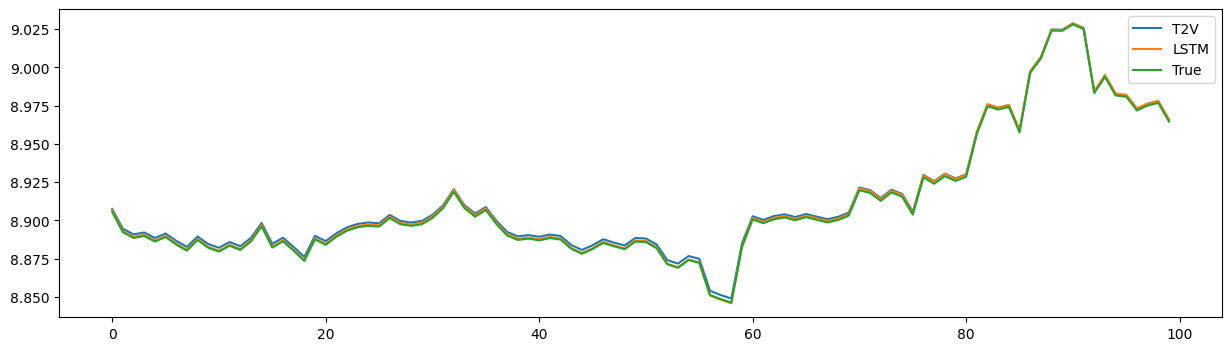

In [86]:
i = randint(101,len(X))

fig, ax = plt.subplots(1,1, figsize=(15, 4))
ax.plot(tsv[-i-100:-i], label="T2V")
ax.plot(lstm[-i-100:-i], label="LSTM")
ax.plot(df.Log_Close.iloc[-i-100:-i].values, label="True")
ax.legend()